# Detecção  em escala aleatória do MNIST

## Importando módulos

In [1]:
import os
import pkgutil

if pkgutil.find_loader('torch') is None:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

import torch
import torchvision
from torchvision.datasets import MNIST

import cv2

In [3]:
np.set_printoptions(precision=1, linewidth=120)
torch.set_printoptions(precision=1, linewidth=120)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device:", device)

Device: cuda


## Dataset

In [5]:
dataset_dir = '../data/MNIST/processed/'
num_scales = 2

In [6]:
class RandomScaleMNIST(torch.utils.data.Dataset):
    def __init__(self, processed_data_dir, length, mat_size=490, num_scales=2, min_size=28, max_size=56, debug=False):
        num_attempts = 20

        digit_size_array = np.arange(min_size, max_size, 2)
        self.digit_size_max_delta = (max_size - min_size) / (2 * num_scales)
        self.digit_size_ref = np.arange(min_size + self.digit_size_max_delta, max_size, (2 * self.digit_size_max_delta))

        num_cells = (mat_size / self.digit_size_ref).astype('int').tolist()
        self.cell_central_pixel = [np.arange(size_ref/2, mat_size, size_ref) for size_ref in self.digit_size_ref]
        cell_pixel_between = [(central_array[:-1] + central_array[1:]) // 2 for central_array in self.cell_central_pixel]

        if debug:
            print(f'digit_size_max_delta: {self.digit_size_max_delta}')
            print(f'digit_size_array: {digit_size_array}')
            print(f'digit_size_ref: {self.digit_size_ref}')
            print(f'num_cells: {num_cells}')
            print(f'cell_central_pixel: {self.cell_central_pixel}')
            print(f'cell_pixel_between: {cell_pixel_between}')
            print('\n')

        self.length = length
        self.num_scales = num_scales

        test_data, test_label = torch.load(os.path.join(processed_data_dir, 'test.pt'))
        train_data, train_label = torch.load(os.path.join(processed_data_dir, 'training.pt'))

        self.joint_data = torch.cat((train_data, test_data), dim=0).type(torch.FloatTensor) / 255.0
        self.joint_label = torch.cat((train_label, test_label), dim=0)

        data_idx_array = np.arange(self.joint_data.shape[0])

        self.mat_image = torch.zeros((self.length, 1, mat_size, mat_size), dtype=torch.float)
        self.mat_label_reg = list()
        self.mat_label_cls = list()
        for entry in num_cells:
            self.mat_label_reg.append(torch.zeros((self.length, 3, entry, entry), dtype=torch.float))
            self.mat_label_cls.append(torch.zeros((self.length, 2, entry, entry), dtype=torch.long))
            self.mat_label_cls[-1][:, 0] = -1

        for sample_idx in range(self.length):
            frame_list = list()

            np.random.shuffle(data_idx_array)
            num_digits = np.random.randint(30, 45)

            for data_idx in range(num_digits):
                digit_idx = data_idx_array[data_idx]
                # Choose digit size among options and get closes size reference
                digit_size = np.random.choice(digit_size_array)
                digit_size_diff = digit_size - self.digit_size_ref

                digit_size_ref_idx = np.argmin(np.abs(digit_size_diff))
                if digit_size_diff[digit_size_ref_idx] == self.digit_size_max_delta:
                    digit_size_ref_idx += 1

                digit_size_delta = digit_size_diff[digit_size_ref_idx]

                digit_attempt = 0
                while digit_attempt != num_attempts:
                    nx1, ny1 = np.random.randint(0, mat_size-digit_size, size=2)
                    nx2, ny2 = nx1+digit_size, ny1+digit_size

                    frame_idx = 0
                    while frame_idx != len(frame_list):
                        frame_x1, frame_y1, frame_x2, frame_y2 = frame_list[frame_idx]

                        nx1_between = (nx1 >= frame_x1) and (nx1 < frame_x2)
                        nx2_between = (nx2 >= frame_x1) and (nx2 < frame_x2)
                        #nx_between = nx1_between or nx2_between

                        ny1_between = (ny1 >= frame_y1) and (ny1 < frame_y2)
                        ny2_between = (ny2 >= frame_y1) and (ny2 < frame_y2)
                        #ny_between = ny1_between or ny2_between

                        frame_x1_between = (frame_x1 >= nx1) and (frame_x1 < nx2)
                        frame_x2_between = (frame_x2 >= nx1) and (frame_x2 < nx2)
                        #frame_x_between = frame_x1_between or frame_x2_between

                        frame_y1_between = (frame_y1 >= ny1) and (frame_y1 < ny2)
                        frame_y2_between = (frame_y2 >= ny1) and (frame_y2 < ny2)
                        #frame_y_between = frame_y1_between or frame_y2_between

                        x_between = nx1_between or nx2_between or frame_x1_between or frame_x2_between
                        y_between = ny1_between or ny2_between or frame_y1_between or frame_y2_between
                        #if (nx_between and ny_between) or (frame_x_between and frame_y_between):
                        if x_between and y_between:
                            break
                        else:
                            frame_idx += 1

                    if frame_idx == len(frame_list):
                        frame_list.append([nx1, ny1, nx2, ny2])
                        break
                    else:
                        digit_attempt += 1

                if digit_attempt != num_attempts:
                    frame = frame_list[-1]
                    self.mat_image[sample_idx, 0,
                                   frame[1]:frame[3],
                                   frame[0]:frame[2]] = torch.from_numpy(cv2.resize(self.joint_data[digit_idx].numpy(),
                                                                                    dsize=(digit_size, digit_size)))

                    # Compute distance of digit centroid to each cell interface to pick the right cell and tx/ty
                    x_centroid = frame[0] + (digit_size // 2)
                    y_centroid = frame[1] + (digit_size // 2)

                    x_centroid_diff = cell_pixel_between[digit_size_ref_idx] - x_centroid
                    y_centroid_diff = cell_pixel_between[digit_size_ref_idx] - y_centroid

                    x_closest_pixel = np.argmin(np.abs(x_centroid_diff))
                    y_closest_pixel = np.argmin(np.abs(y_centroid_diff))

                    x_central_pixel_idx = x_closest_pixel if x_centroid_diff[x_closest_pixel] >= 0 else x_closest_pixel + 1
                    y_central_pixel_idx = y_closest_pixel if y_centroid_diff[y_closest_pixel] >= 0 else y_closest_pixel + 1

                    x_central_pixel = self.cell_central_pixel[digit_size_ref_idx][x_central_pixel_idx]
                    y_central_pixel = self.cell_central_pixel[digit_size_ref_idx][y_central_pixel_idx]

                    tx = cell_pixel_between[digit_size_ref_idx][x_closest_pixel] - x_centroid_diff[x_closest_pixel] - x_central_pixel
                    ty = cell_pixel_between[digit_size_ref_idx][y_closest_pixel] - y_centroid_diff[y_closest_pixel] - y_central_pixel

                    self.mat_label_reg[digit_size_ref_idx][sample_idx, 0, y_central_pixel_idx, x_central_pixel_idx] = tx
                    self.mat_label_reg[digit_size_ref_idx][sample_idx, 1, y_central_pixel_idx, x_central_pixel_idx] = ty
                    self.mat_label_reg[digit_size_ref_idx][sample_idx, 2, y_central_pixel_idx, x_central_pixel_idx] = digit_size_delta
                    self.mat_label_cls[digit_size_ref_idx][sample_idx, 0, y_central_pixel_idx, x_central_pixel_idx] = self.joint_label[digit_idx]
                    self.mat_label_cls[digit_size_ref_idx][sample_idx, 1, y_central_pixel_idx, x_central_pixel_idx] = 1

                    #if debug:
                    #    print(f'Digit {data_idx+1}: Class:{self.joint_label[digit_idx]} | Size:{digit_size} | dW:{digit_size_delta} | tx:{tx} | ty:{ty} | Coord:{frame}')

        if not debug:
            for idx in range(len(self.mat_label_reg)):
                self.mat_label_reg[idx][:, :2] /= self.digit_size_ref[idx] / 2
                self.mat_label_reg[idx][:, 2] /= self.digit_size_max_delta

    def getDigitSize(self):
        return self.digit_size_ref

    def getDigitSizeMaxDelta(self):
        return self.digit_size_max_delta

    def getCellCentralRef(self):
        return self.cell_central_pixel

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        label_reg = list()
        label_cls = list()

        for scale in range(self.num_scales):
            label_reg.append(self.mat_label_reg[scale][index])
            label_cls.append(self.mat_label_cls[scale][index])

        return self.mat_image[index], label_reg, label_cls

### Visualização de exemplo

In [7]:
def printSample(dataset, idx):
    image, label_reg_list, label_cls_list = dataset[idx]

    for scale_idx in range(num_scales):
        print(f'\nScale {scale_idx}')
        print(f'tx:\n{label_reg_list[scale_idx][0]}\n')
        print(f'ty:\n{label_reg_list[scale_idx][1]}\n')
        print(f'dW:\n{label_reg_list[scale_idx][2]}\n')
        print(f'class:\n{label_cls_list[scale_idx][0]}\n')
        print(f'presence:\n{label_cls_list[scale_idx][1]}\n')

def vizSample(dataset, idx, digit_size_array, digit_central_ref_array):
    text_fontsize = 14

    image, label_reg_list, label_cls_list = dataset[idx]

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image[0].numpy(), cmap='Greys')
    ax.grid(False)
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    digit_info = list()
    digit_idx = 0

    for scale_idx in range(num_scales):
        digit_central_ref = digit_central_ref_array[scale_idx]

        label_reg = label_reg_list[scale_idx]
        label_cls = label_cls_list[scale_idx]

        digit_size_mat = digit_size_array[scale_idx] + label_reg[2]

        digit_coord_array = label_cls[1].nonzero()
        for digit_coord in digit_coord_array:
            digit_coord_y = digit_coord[0].item()
            digit_coord_x = digit_coord[1].item()

            digit_size = int(digit_size_mat[digit_coord_y, digit_coord_x].item())
            delta_size = digit_size / 2

            digit_x = (digit_central_ref[digit_coord_x] + label_reg[0][digit_coord_y, digit_coord_x]).item() - delta_size
            digit_y = (digit_central_ref[digit_coord_y] + label_reg[1][digit_coord_y, digit_coord_x]).item() - delta_size

            digit_info.append({
                'Class': label_cls[0][digit_coord_y, digit_coord_x].item(),
                'Size': digit_size,
                'dW': label_reg[2][digit_coord_y, digit_coord_x].item(),
                'tx': label_reg[0][digit_coord_y, digit_coord_x].item(),
                'ty': label_reg[1][digit_coord_y, digit_coord_x].item(),
                'Coord': [digit_x, digit_y, digit_x+digit_size, digit_y+digit_size]
            })

            ax.add_patch(patches.Rectangle([digit_x, digit_y], digit_size, digit_size,
                                           fill=False, edgecolor='blue', lw=2))
            ax.text(digit_x, digit_y+(text_fontsize//2), str(digit_idx), fontsize=text_fontsize)

            digit_idx += 1

    key_list = ['Class', 'Size', 'dW', 'tx', 'ty', 'Coord']

    for idx in range(digit_idx):
        digit_str = f'Digit {idx} > '

        for key in key_list:
            digit_str += f'{key}:{digit_info[idx][key]}'
            if key != key_list[-1]:
                digit_str += ' | '

        print(digit_str)

    #plt.axis('off')
    plt.show()

In [8]:
mnist_dataset = RandomScaleMNIST(dataset_dir, 1, num_scales=num_scales, debug=True)
digit_size_array = mnist_dataset.getDigitSize()
digit_size_max_delta = mnist_dataset.getDigitSizeMaxDelta()
digit_central_ref_array = mnist_dataset.getCellCentralRef()

digit_size_max_delta: 7.0
digit_size_array: [28 30 32 34 36 38 40 42 44 46 48 50 52 54]
digit_size_ref: [35. 49.]
num_cells: [14, 10]
cell_central_pixel: [array([ 17.5,  52.5,  87.5, 122.5, 157.5, 192.5, 227.5, 262.5, 297.5, 332.5, 367.5, 402.5, 437.5, 472.5]), array([ 24.5,  73.5, 122.5, 171.5, 220.5, 269.5, 318.5, 367.5, 416.5, 465.5])]
cell_pixel_between: [array([ 35.,  70., 105., 140., 175., 210., 245., 280., 315., 350., 385., 420., 455.]), array([ 49.,  98., 147., 196., 245., 294., 343., 392., 441.])]




Digit 0 > Class:2 | Size:34 | dW:-1.0 | tx:11.5 | ty:2.5 | Coord:[12.0, 3.0, 46.0, 37.0]
Digit 1 > Class:7 | Size:38 | dW:3.0 | tx:7.5 | ty:5.5 | Coord:[111.0, 4.0, 149.0, 42.0]
Digit 2 > Class:4 | Size:30 | dW:-5.0 | tx:-16.5 | ty:11.5 | Coord:[301.0, 49.0, 331.0, 79.0]
Digit 3 > Class:8 | Size:40 | dW:5.0 | tx:-11.5 | ty:-5.5 | Coord:[56.0, 62.0, 96.0, 102.0]
Digit 4 > Class:3 | Size:40 | dW:5.0 | tx:0.5 | ty:5.5 | Coord:[138.0, 108.0, 178.0, 148.0]
Digit 5 > Class:7 | Size:30 | dW:-5.0 | tx:-8.5 | ty:10.5 | Coord:[309.0, 118.0, 339.0, 148.0]
Digit 6 > Class:2 | Size:38 | dW:3.0 | tx:14.5 | ty:-8.5 | Coord:[13.0, 130.0, 51.0, 168.0]
Digit 7 > Class:1 | Size:40 | dW:5.0 | tx:12.5 | ty:16.5 | Coord:[325.0, 154.0, 365.0, 194.0]
Digit 8 > Class:8 | Size:36 | dW:1.0 | tx:-9.5 | ty:6.5 | Coord:[375.0, 181.0, 411.0, 217.0]
Digit 9 > Class:8 | Size:38 | dW:3.0 | tx:-3.5 | ty:-1.5 | Coord:[310.0, 207.0, 348.0, 245.0]
Digit 10 > Class:4 | Size:34 | dW:-1.0 | tx:-6.5 | ty:-14.5 | Coord:[414.0, 

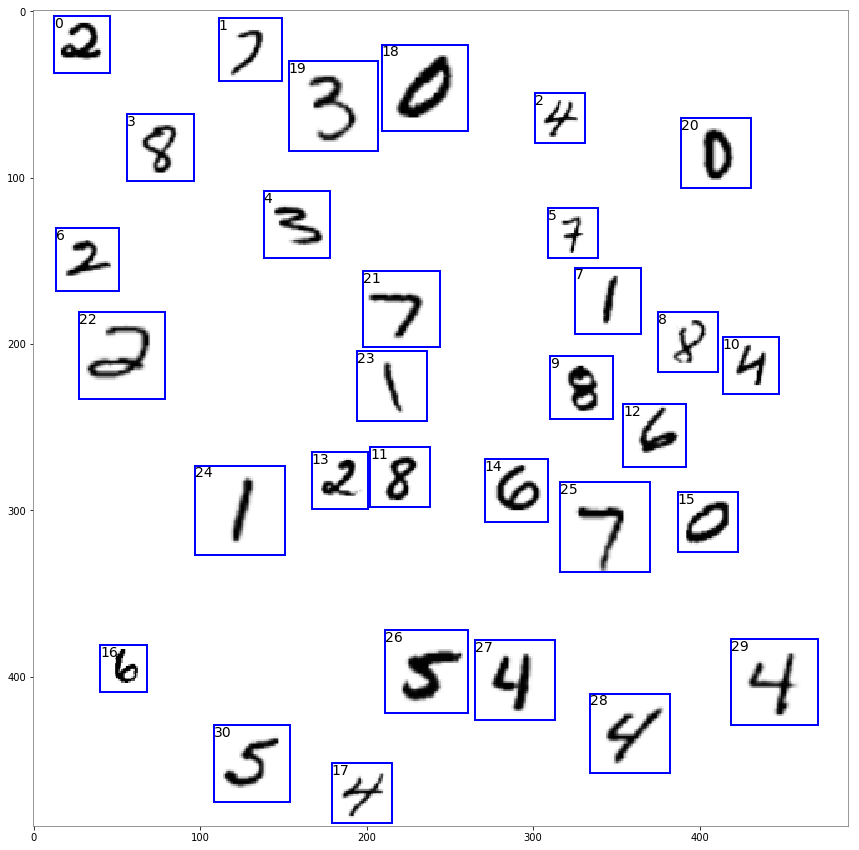

In [9]:
vizSample(mnist_dataset, 0, digit_size_array, digit_central_ref_array)

In [10]:
printSample(mnist_dataset, 0)


Scale 0
tx:
tensor([[ 11.5,   0.0,   0.0,   7.5,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0],
        [  0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0, -16.5,   0.0,   0.0,   0.0,   0.0],
        [  0.0,   0.0, -11.5,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0],
        [  0.0,   0.0,   0.0,   0.0,   0.5,   0.0,   0.0,   0.0,   0.0,  -8.5,   0.0,   0.0,   0.0,   0.0],
        [ 14.5,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,  12.5,   0.0,   0.0,   0.0,   0.0],
        [  0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,  -9.5,   0.0,   0.0],
        [  0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.0,  -3.5,   0.0,   0.0,  -6.5,   0.0],
        [  0.0,   0.0,   0.0,   0.0,   0.0,   0.0,  -7.5,   0.0,   0.0,   0.0,   5.5,   0.0,   0.0,   0.0],
        [  0.0,   0.0,   0.0,   0.0,   0.0,  -8.5,   0.0,   0.0,  -7.5,   0.0,   0.0,   2.5,   0.0,   0.0],
        [  0.0,

### Criação dos datasets de Treinamento, Validação e Teste

In [11]:
num_samples_train = 6000
num_samples_valid = 1200
num_samples_test = 600

dataset_train = RandomScaleMNIST(dataset_dir, num_samples_train, num_scales=num_scales)
dataset_valid = RandomScaleMNIST(dataset_dir, num_samples_valid, num_scales=num_scales)
dataset_test = RandomScaleMNIST(dataset_dir, num_samples_test, num_scales=num_scales)

## Dataloaders

In [12]:
batch_size = 6

dataloaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)
}

## Modelo de Rede Neural

In [13]:
class RandomScaleModel(torch.nn.Module):
    def __init__(self):
        super(RandomScaleModel, self).__init__()

        self.act_func = torch.nn.LeakyReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

        self.conv01 = torch.nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3, padding=1)
        self.conv02 = torch.nn.Conv2d(in_channels=48, out_channels=45, kernel_size=3)
        self.conv03 = torch.nn.Conv2d(in_channels=45, out_channels=42, kernel_size=3, padding=1)
        self.conv04 = torch.nn.Conv2d(in_channels=42, out_channels=39, kernel_size=3, padding=1)
        self.conv05 = torch.nn.Conv2d(in_channels=39, out_channels=36, kernel_size=3, padding=1)
        self.conv06 = torch.nn.Conv2d(in_channels=36, out_channels=33, kernel_size=3)
        self.conv07 = torch.nn.Conv2d(in_channels=33, out_channels=30, kernel_size=3, padding=1)
        self.conv08 = torch.nn.Conv2d(in_channels=30, out_channels=27, kernel_size=3)
        self.conv09 = torch.nn.Conv2d(in_channels=27, out_channels=24, kernel_size=3)
        self.conv10 = torch.nn.Conv2d(in_channels=24, out_channels=21, kernel_size=3, padding=1)
        self.conv11 = torch.nn.Conv2d(in_channels=21, out_channels=18, kernel_size=3, padding=1)
        self.conv12 = torch.nn.Conv2d(in_channels=18, out_channels=15, kernel_size=3, padding=1)
        self.conv13 = torch.nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3)
        self.conv14 = torch.nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3)

    def forward(self, x):
        x = self.conv01(x)    #  48 x 490 x 490
        x = self.act_func(x)
        x = self.conv02(x)    #  45 x 488 x 488
        x = self.act_func(x)
        x = self.maxpool(x)   #  45 x 244 x 244

        x = self.conv03(x)    #  42 x 244 x 244
        x = self.act_func(x)
        x = self.conv04(x)    #  39 x 244 x 244
        x = self.act_func(x)
        x = self.maxpool(x)   #  39 x 122 x 122

        x = self.conv05(x)    #  36 x 122 x 122
        x = self.act_func(x)
        x = self.conv06(x)    #  33 x 120 x 120
        x = self.act_func(x)
        x = self.maxpool(x)   #  33 x  60 x  60

        x = self.conv07(x)    #  30 x  60 x  60
        x = self.act_func(x)
        x = self.conv08(x)    #  27 x  58 x  58
        x = self.act_func(x)
        x = self.conv09(x)    #  24 x  56 x  56
        x = self.act_func(x)
        x = self.maxpool(x)   #  24 x  28 x  28

        x = self.conv10(x)    #  21 x  28 x  28
        x = self.act_func(x)
        x = self.conv11(x)    #  18 x  28 x  28
        x = self.act_func(x)
        x = self.maxpool(x)   #  18 x  14 x  14

        x = self.conv12(x)    #  15 x  14 x  14
        x = self.act_func(x)
        y = self.conv13(x)    #  15 x  12 x  12
        y = self.act_func(y)
        y = self.conv14(y)    #  15 x  10 x  10
        y = self.act_func(y)

        return [x, y]

## Função de perda customizada

In [14]:
class RandomScaleLoss(torch.nn.Module):
    def __init__(self, num_scales=2):
        super().__init__()
        self.num_scales = num_scales

        presence_weights = torch.tensor([0.1, 1]).to(device)
        self.cel_presence = torch.nn.CrossEntropyLoss(weight=presence_weights)
        self.cel_class = torch.nn.CrossEntropyLoss(ignore_index=-1)

    def customMSELoss(self, predict, target, mask):
        num_elem = torch.sum(mask, (3, 2, 1))
        mse_loss_calc_1 = (predict - target) ** 2
        mse_loss_calc_2 = torch.sum(mse_loss_calc_1 * mask, (3, 2, 1)) / num_elem
        return torch.sum(mse_loss_calc_2) / len(mse_loss_calc_2)

    def forward(self, predict_list, target_reg_list, target_cls_list):
        # predict: M, 14, 10, 10
        loss_presence = list()
        loss_class = list()
        loss_t = list()

        for scale_idx in range(self.num_scales):
            predict_scale = predict_list[scale_idx].to(device)
            target_reg_scale = target_reg_list[scale_idx].to(device)
            target_cls_scale = target_cls_list[scale_idx].to(device)

            loss_presence.append(self.cel_presence(predict_scale[:, 13:], target_cls_scale[:, 1]))
            loss_class.append(self.cel_class(predict_scale[:, 3:13], target_cls_scale[:, 0]))
            loss_t.append(self.customMSELoss(predict_scale[:, :3], target_reg_scale,
                                             target_cls_scale[:, 1:].type(torch.float)))

        return sum(loss_presence + loss_class + loss_t)

## Teste das etapas (dataloader, modelo e função de perda)

In [15]:
label_entries = ['tx', 'ty', 'class', 'presence']

dataiter = iter(dataloaders['train'])
sample_images, sample_labels_reg_list, sample_labels_cls_list = dataiter.next()

print(f'Input')
print(f'    Format: {sample_images.shape}')
print(f'    Type: {sample_images.dtype}')
print(f'    Range: [{sample_images.min()}, {sample_images.max()}]')
print('\n')

print(f'Label')
for scale_idx in range(num_scales):
    print(f'    Scale {scale_idx}')
    print(f'        Regression')
    print(f'            Format: {sample_labels_reg_list[scale_idx].shape}')
    print(f'            Type: {sample_labels_reg_list[scale_idx].dtype}')
    print(f'            Range:')
    print(f'                tx: [{sample_labels_reg_list[scale_idx][:, 0].min()}, {sample_labels_reg_list[scale_idx][:, 0].max()}]')
    print(f'                ty: [{sample_labels_reg_list[scale_idx][:, 1].min()}, {sample_labels_reg_list[scale_idx][:, 1].max()}]')
    print(f'                dW: [{sample_labels_reg_list[scale_idx][:, 2].min()}, {sample_labels_reg_list[scale_idx][:, 2].max()}]')
    print(f'        Classification')
    print(f'            Format: {sample_labels_cls_list[scale_idx].shape}')
    print(f'            Type: {sample_labels_cls_list[scale_idx].dtype}')
    print(f'            Range:')
    print(f'                class: [{sample_labels_cls_list[scale_idx][:, 0].min()}, {sample_labels_cls_list[scale_idx][:, 0].max()}]')
    print(f'                presence: [{sample_labels_cls_list[scale_idx][:, 1].min()}, {sample_labels_cls_list[scale_idx][:, 1].max()}]')

Input
    Format: torch.Size([6, 1, 490, 490])
    Type: torch.float32
    Range: [0.0, 1.0]


Label
    Scale 0
        Regression
            Format: torch.Size([6, 3, 14, 14])
            Type: torch.float32
            Range:
                tx: [-0.9428571462631226, 1.0]
                ty: [-0.9428571462631226, 1.0]
                dW: [-1.0, 0.7142857313156128]
        Classification
            Format: torch.Size([6, 2, 14, 14])
            Type: torch.int64
            Range:
                class: [-1, 9]
                presence: [0, 1]
    Scale 1
        Regression
            Format: torch.Size([6, 3, 10, 10])
            Type: torch.float32
            Range:
                tx: [-0.9591836929321289, 1.0]
                ty: [-0.9591836929321289, 1.0]
                dW: [-1.0, 0.7142857313156128]
        Classification
            Format: torch.Size([6, 2, 10, 10])
            Type: torch.int64
            Range:
                class: [-1, 9]
                presence: 

In [16]:
random_scale_model = RandomScaleModel().to(device)
sample_images = sample_images.to(device)
output_list = random_scale_model(sample_images)

print(f'Output')
for scale_idx in range(num_scales):
    print(f'    Scale {num_scales - scale_idx}')
    print(f'        Format: {output_list[scale_idx].shape}')
    print(f'        Type: {output_list[scale_idx].dtype}')
    print(f'        Range: [{output_list[scale_idx].min()}, {output_list[scale_idx].max()}]')

Output
    Scale 2
        Format: torch.Size([6, 15, 14, 14])
        Type: torch.float32
        Range: [-0.0007273585069924593, 0.07871488481760025]
    Scale 1
        Format: torch.Size([6, 15, 10, 10])
        Type: torch.float32
        Range: [-0.000961566052865237, 0.090911865234375]


In [17]:
crit = RandomScaleLoss(num_scales=num_scales)
loss = crit(output_list, sample_labels_reg_list, sample_labels_cls_list)
print(f'loss: {loss}')

loss: 8.092852592468262


## Treinamento

In [18]:
n_epochs = 100
epoch_train_loss_history = list()
epoch_valid_loss_history = list()

optm = torch.optim.Adam(params=random_scale_model.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)

In [19]:
def train_session(model, dataloaders, num_epochs, optimizer, criterion, epoch_train_loss_history, epoch_valid_loss_history):
    num_train_samples = len(dataloaders['train'].dataset)
    num_valid_samples = len(dataloaders['valid'].dataset)
    train_batch_size = dataloaders['train'].batch_size
    valid_batch_size = dataloaders['valid'].batch_size

    num_train_batches = num_train_samples // train_batch_size
    num_valid_batches = num_valid_samples // valid_batch_size

    batch_print_size = 10

    print('Start training for {} epochs'.format(num_epochs))

    try:
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            train_t0 = time.time()
            epoch_train_loss = 0.0
            running_loss = 0.0

            for i, samples in enumerate(dataloaders['train']):
                # get the inputs
                images = samples[0].to(device)
                labels_reg_list = samples[1]
                labels_cls_list = samples[2]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output_list = model(images)
                loss = criterion(output_list, labels_reg_list, labels_cls_list)
                loss_value = loss.cpu().item()
                loss.backward()
                optimizer.step()

                # Update loss totals
                running_loss += loss_value
                epoch_train_loss += loss_value

                # print statistics
                if i % batch_print_size == (batch_print_size - 1):
                    print(f'Train batch {i+1}/{num_train_batches}: loss {running_loss/batch_print_size}', end='\r')
                    running_loss = 0.0

            epoch_train_loss /= num_train_samples
            train_t1 = time.time() - train_t0


            valid_t0 = time.time()
            epoch_valid_loss = 0.0
            running_loss = 0.0

            with torch.no_grad():
                for i, samples in enumerate(dataloaders['valid']):
                    # get the inputs
                    images = samples[0].to(device)
                    labels_reg_list = samples[1]
                    labels_cls_list = samples[2]

                    # forward
                    output_list = model(images)
                    loss = criterion(output_list, labels_reg_list, labels_cls_list)
                    loss_value = loss.cpu().item()

                    # Update loss totals
                    running_loss += loss_value
                    epoch_valid_loss += loss_value

                    # print statistics
                    if i % batch_print_size == (batch_print_size - 1):
                        print(f'Valid batch {i+1}/{num_valid_batches}: loss {running_loss/batch_print_size}', end='\r')
                        running_loss = 0.0

            epoch_valid_loss /= num_valid_samples
            valid_t1 = time.time() - valid_t0

            epoch_train_loss_history.append(epoch_train_loss)
            epoch_valid_loss_history.append(epoch_valid_loss)

            print(f'Epoch {epoch:3d} > train: T={train_t1:5.1f}s | loss={epoch_train_loss}  valid: T={valid_t1:5.1f}s | loss={epoch_valid_loss}')

        print('Finished Training')
    except KeyboardInterrupt:
        print('Finished by user')
        
    return epoch_train_loss_history, epoch_valid_loss_history

In [20]:
def save_loss_history(loss_history_list, loss_history_filename):
    file_obj = open(loss_history_filename, 'w')
    for entry in loss_history_list:
        file_obj.write(str(entry) + '\n')
    file_obj.close()

def load_loss_history(loss_history_filename):
    loss_history_list = list()

    file_obj = open(loss_history_filename, 'r')
    for line in file_obj:
        loss_history_list.append(float(line.strip()))
    file_obj.close()

    return loss_history_list

In [21]:
train = True
load_previous_state = True
epoch_train_loss_history_filename = 'epoch_train_loss_history.txt'
epoch_valid_loss_history_filename = 'epoch_valid_loss_history.txt'
saved_model_filename = './random_scale_model'

In [22]:
if load_previous_state:
    random_scale_model.load_state_dict(torch.load(saved_model_filename))
    epoch_train_loss_history = load_loss_history(epoch_train_loss_history_filename)
    epoch_valid_loss_history = load_loss_history(epoch_valid_loss_history_filename)

if train:
    epoch_train_loss_history, epoch_valid_loss_history = train_session(random_scale_model, dataloaders, n_epochs, optm, crit)
    torch.save(random_scale_model.state_dict(), saved_model_filename)
    save_loss_history(epoch_train_loss_history, epoch_train_loss_history_filename)
    save_loss_history(epoch_valid_loss_history, epoch_valid_loss_history_filename)

Start training for 100 epochs
Epoch   0 > train: T=590.2s | loss=1.2641148277918497  valid: T= 36.8s | loss=1.2223007488250732
Epoch   1 > train: T=586.5s | loss=1.2109425446987152  valid: T= 36.2s | loss=1.1989412860075632
Epoch   2 > train: T=586.5s | loss=1.1930147484938303  valid: T= 36.2s | loss=1.1879598291714986
Epoch   3 > train: T=587.0s | loss=1.18255517800649  valid: T= 36.2s | loss=1.1780820004145305
Epoch   4 > train: T=586.8s | loss=1.1759944211641948  valid: T= 36.2s | loss=1.1724843343098958
Epoch   5 > train: T=587.1s | loss=1.1701830077171325  valid: T= 36.1s | loss=1.1652071682612102
Epoch   6 > train: T=586.9s | loss=1.1644633740584056  valid: T= 36.1s | loss=1.168728866179784
Epoch   7 > train: T=586.9s | loss=1.1593366787433623  valid: T= 36.1s | loss=1.1547395626703898
Epoch   8 > train: T=586.9s | loss=1.1535666625499725  valid: T= 36.1s | loss=1.1498640127976736
Epoch   9 > train: T=587.0s | loss=1.1488128050168356  valid: T= 36.1s | loss=1.1463344752788545
Epo

Epoch  84 > train: T=587.1s | loss=0.5513299681345621  valid: T= 36.3s | loss=0.5704007254044214
Epoch  85 > train: T=587.3s | loss=0.5512465842167537  valid: T= 36.1s | loss=0.575502690076828
Epoch  86 > train: T=587.5s | loss=0.5488519038359324  valid: T= 36.2s | loss=0.5612660078207652
Epoch  87 > train: T=587.2s | loss=0.5465913272301356  valid: T= 36.1s | loss=0.5786464069286982
Epoch  88 > train: T=587.6s | loss=0.5494646704991658  valid: T= 36.1s | loss=0.5964440876245498
Epoch  89 > train: T=587.2s | loss=0.5473306443293889  valid: T= 36.2s | loss=0.5663660442829133
Epoch  90 > train: T=587.6s | loss=0.551162673830986  valid: T= 36.1s | loss=0.5626371850570043
Epoch  91 > train: T=587.1s | loss=0.5384982090393702  valid: T= 36.1s | loss=0.5754549461603164
Epoch  92 > train: T=587.4s | loss=0.5435789343516032  valid: T= 36.1s | loss=0.5625870847702026
Epoch  93 > train: T=587.5s | loss=0.5369497201045355  valid: T= 36.1s | loss=0.5558147199948629
Epoch  94 > train: T=587.2s | lo

### Evolução do treinamento

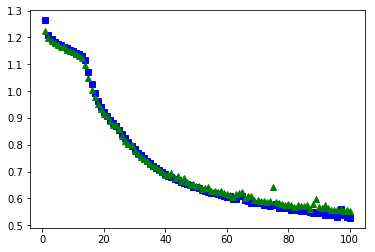

In [23]:
a_epochs = np.arange(1, 1 + len(epoch_train_loss_history))
plt.plot(a_epochs, epoch_train_loss_history, 'bs', a_epochs, epoch_valid_loss_history, 'g^')
plt.show()

### Cálculo da acurácia no conjunto de testes

In [24]:
test_loss = list()

test_image = list()

test_label_reg = dict()
test_label_class = dict()
test_label_presence = dict()

test_output_reg = dict()
test_output_class = dict()
test_output_presence = dict()

for scale_idx in range(num_scales):
    test_label_reg[scale_idx] = list()
    test_label_class[scale_idx] = list()
    test_label_presence[scale_idx] = list()

    test_output_reg[scale_idx] = list()
    test_output_class[scale_idx] = list()
    test_output_presence[scale_idx] = list()

with torch.no_grad():
    for i, samples in enumerate(dataset_test):
        # get the inputs
        images = samples[0].unsqueeze(0).to(device)

        labels_reg_list = list()
        labels_cls_list = list()
        for scale_idx in range(num_scales):
            labels_reg_list.append(samples[1][scale_idx].unsqueeze(0))
            labels_cls_list.append(samples[2][scale_idx].unsqueeze(0))

        # forward
        output_list = random_scale_model(images)
        loss = crit(output_list, labels_reg_list, labels_cls_list)

        test_loss.append(loss.cpu().item())

        test_image.append(samples[0].numpy())

        for scale_idx in range(num_scales):
            scale = num_scales - scale_idx
            test_label_reg[scale_idx].append(samples[1][scale_idx].numpy())
            test_output_reg[scale_idx].append(output_list[scale_idx][0, 0:3].cpu().numpy())

            samples_cls_array = samples[2][scale_idx].numpy()
            test_label_class[scale_idx].append(samples_cls_array[0])
            test_output_class[scale_idx].append(np.argmax(output_list[scale_idx][0, 3:13].cpu().numpy(), axis=0))

            test_label_presence[scale_idx].append(samples_cls_array[1])
            test_output_presence[scale_idx].append(np.argmax(output_list[scale_idx][0, 13:].cpu().numpy(), axis=0))

In [25]:
test_loss_array = np.array(test_loss)
test_loss_idx = np.argsort(test_loss_array)

test_arrays = {
    'image_array': np.concatenate(test_image),
    'label_reg_array': dict(),
    'output_reg_array': dict(),
    'label_class_array': dict(),
    'output_class_array': dict(),
    'label_presence_array': dict(),
    'output_presence_array': dict()
}

for scale_idx in range(num_scales):
    test_arrays['label_reg_array'][scale_idx] = np.stack(test_label_reg[scale_idx])
    test_arrays['output_reg_array'][scale_idx] = np.stack(test_output_reg[scale_idx])
    test_arrays['label_class_array'][scale_idx] = np.stack(test_label_class[scale_idx])
    test_arrays['output_class_array'][scale_idx] = np.stack(test_output_class[scale_idx])
    test_arrays['label_presence_array'][scale_idx] = np.stack(test_label_presence[scale_idx])
    test_arrays['output_presence_array'][scale_idx] = np.stack(test_output_presence[scale_idx])

    test_arrays['label_reg_array'][scale_idx][:, :2] *= (digit_size_array[scale_idx] / 2)
    test_arrays['label_reg_array'][scale_idx][:, 2] *= digit_size_max_delta
    test_arrays['output_reg_array'][scale_idx][:, :2] *= (digit_size_array[scale_idx] / 2)
    test_arrays['output_reg_array'][scale_idx][:, 2] *= digit_size_max_delta

In [26]:
num_digits = 0
correct_digits = 0

for scale_idx in range(num_scales):
    predicted_digits = (test_arrays['output_class_array'][scale_idx] * test_arrays['output_presence_array'][scale_idx])
    num_digits += np.sum(test_arrays['label_presence_array'][scale_idx])
    correct_digits += np.sum(predicted_digits == test_arrays['label_class_array'][scale_idx])

print(f'Acurácia: {correct_digits * 100.0 / num_digits:2.3f}%')

Acurácia: 83.109%


In [27]:
def vizResult(arrays_dict, idx, digit_size_array, digit_central_ref_array):
    text_fontsize = 14
    bbox_color_dict = {
        'label': 'blue',
        'output': 'red'
    }

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(arrays_dict['image_array'][idx], cmap='Greys')
    ax.grid(False)
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    digit_info = {
        'label': list(),
        'output': list()
    }

    digit_idx = {
        'label': 0,
        'output': 0
    }

    for scale_idx in range(num_scales):
        digit_central_ref = digit_central_ref_array[scale_idx]

        reg_dict = dict()
        class_dict = dict()
        presence_dict = dict()
        digit_size_mat_dict = dict()
        digit_coord_array_dict = dict()

        reg_dict['label'] = arrays_dict["label_reg_array"][scale_idx][idx]
        class_dict['label'] = arrays_dict["label_class_array"][scale_idx][idx]
        presence_dict['label'] = arrays_dict["label_presence_array"][scale_idx][idx]

        #reg_dict['label'][:2] *= (digit_size_array[scale_idx] / 2)
        #reg_dict['label'][2] *= digit_size_max_delta

        reg_dict['output'] = arrays_dict["output_reg_array"][scale_idx][idx]
        class_dict['output'] = arrays_dict["output_class_array"][scale_idx][idx]
        presence_dict['output'] = arrays_dict["output_presence_array"][scale_idx][idx]

        #reg_dict['output'][:2] *= (digit_size_array[scale_idx] / 2)
        #reg_dict['output'][2] *= digit_size_max_delta

        digit_size_mat_dict['label'] = digit_size_array[scale_idx] + reg_dict['label'][2]
        digit_size_mat_dict['output'] = digit_size_array[scale_idx] + reg_dict['output'][2]

        digit_coord_array_dict['label'] = presence_dict['label'].nonzero()
        digit_coord_array_dict['output'] = presence_dict['output'].nonzero()

        for key in ['label', 'output']:
            for digit_coord_idx in range(len(digit_coord_array_dict[key][0])):
                digit_coord_y = digit_coord_array_dict[key][0][digit_coord_idx]
                digit_coord_x = digit_coord_array_dict[key][1][digit_coord_idx]

                digit_size = int(digit_size_mat_dict[key][digit_coord_y, digit_coord_x])
                delta_size = digit_size / 2

                digit_x = (digit_central_ref[digit_coord_x] + reg_dict[key][0][digit_coord_y, digit_coord_x]) - delta_size
                digit_y = (digit_central_ref[digit_coord_y] + reg_dict[key][1][digit_coord_y, digit_coord_x]) - delta_size

                digit_info[key].append({
                    'Class': class_dict[key][digit_coord_y, digit_coord_x],
                    'Size': digit_size,
                    'dW': reg_dict[key][2][digit_coord_y, digit_coord_x],
                    'tx': reg_dict[key][0][digit_coord_y, digit_coord_x],
                    'ty': reg_dict[key][1][digit_coord_y, digit_coord_x],
                    'Coord': np.array([digit_x, digit_y, digit_x+digit_size, digit_y+digit_size])
                })

                ax.add_patch(patches.Rectangle([digit_x, digit_y], digit_size, digit_size,
                                               fill=False, edgecolor=bbox_color_dict[key], lw=2))
                ax.text(digit_x, digit_y+(text_fontsize//2), str(digit_idx[key]), fontsize=text_fontsize, color=bbox_color_dict[key])

                digit_idx[key] += 1

    info_list = ['Class', 'Size', 'dW', 'tx', 'ty', 'Coord']

    print('label')
    for idx in range(digit_idx['label']):
        digit_str = f'Digit {idx} > '

        for info in info_list:
            try:
                digit_str += f'{info}:{digit_info["label"][idx][info]:5.1f}'
            except:
                digit_str += f'{info}:{digit_info["label"][idx][info]}'
            if info != info_list[-1]:
                digit_str += ' | '

        print(digit_str)

    print('\n')

    print('output')
    for idx in range(digit_idx['output']):
        digit_str = f'Digit {idx} > '

        for info in info_list:
            try:
                digit_str += f'{info}:{digit_info["output"][idx][info]:5.1f}'
            except:
                digit_str += f'{info}:{digit_info["output"][idx][info]}'
            if info != info_list[-1]:
                digit_str += ' | '

        print(digit_str)

    plt.show()

### Exemplo com menor perda

label
Digit 0 > Class:  8.0 | Size: 34.0 | dW: -1.0 | tx:-11.5 | ty:  6.5 | Coord:[ 94.   7. 128.  41.]
Digit 1 > Class:  9.0 | Size: 40.0 | dW:  5.0 | tx:  2.5 | ty:  6.5 | Coord:[140.   4. 180.  44.]
Digit 2 > Class:  9.0 | Size: 36.0 | dW:  1.0 | tx: -5.5 | ty:  9.5 | Coord:[309.   9. 345.  45.]
Digit 3 > Class:  9.0 | Size: 32.0 | dW: -3.0 | tx:  5.5 | ty: 11.5 | Coord:[252.  48. 284.  80.]
Digit 4 > Class:  3.0 | Size: 38.0 | dW:  3.0 | tx: -7.5 | ty: -0.5 | Coord:[446.  68. 484. 106.]
Digit 5 > Class:  7.0 | Size: 34.0 | dW: -1.0 | tx:-12.5 | ty: 11.5 | Coord:[443. 117. 477. 151.]
Digit 6 > Class:  3.0 | Size: 36.0 | dW:  1.0 | tx: 17.5 | ty:-16.5 | Coord:[332. 158. 368. 194.]
Digit 7 > Class:  6.0 | Size: 28.0 | dW: -7.0 | tx: 13.5 | ty: -1.5 | Coord:[262. 212. 290. 240.]
Digit 8 > Class:  8.0 | Size: 28.0 | dW: -7.0 | tx: 13.5 | ty:-12.5 | Coord:[122. 271. 150. 299.]
Digit 9 > Class:  6.0 | Size: 38.0 | dW:  3.0 | tx:  3.5 | ty:  1.5 | Coord:[142. 350. 180. 388.]
Digit 10 > Cla

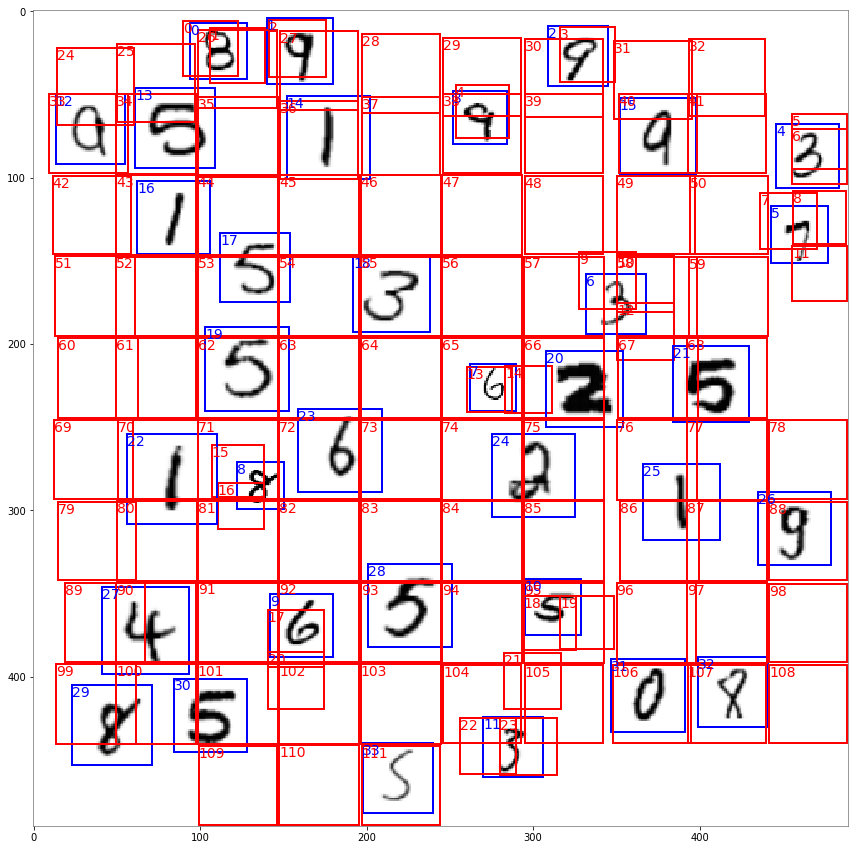

In [28]:
vizResult(test_arrays, test_loss_idx[0], digit_size_array, digit_central_ref_array)

### Exemplo com maior perda

label
Digit 0 > Class:  1.0 | Size: 32.0 | dW: -3.0 | tx:  8.5 | ty:  7.5 | Coord:[185.   9. 217.  41.]
Digit 1 > Class:  5.0 | Size: 34.0 | dW: -1.0 | tx: -5.5 | ty:  6.5 | Coord:[65. 42. 99. 76.]
Digit 2 > Class:  6.0 | Size: 30.0 | dW: -5.0 | tx:  6.5 | ty:  1.5 | Coord:[359.  39. 389.  69.]
Digit 3 > Class:  1.0 | Size: 40.0 | dW:  5.0 | tx:-12.5 | ty: 12.5 | Coord:[405.  45. 445.  85.]
Digit 4 > Class:  9.0 | Size: 34.0 | dW: -1.0 | tx:  0.5 | ty: -3.5 | Coord:[  1.  67.  35. 101.]
Digit 5 > Class:  4.0 | Size: 36.0 | dW:  1.0 | tx:  4.5 | ty: -0.5 | Coord:[  4. 139.  40. 175.]
Digit 6 > Class:  9.0 | Size: 34.0 | dW: -1.0 | tx: -4.5 | ty: -8.5 | Coord:[101. 167. 135. 201.]
Digit 7 > Class:  2.0 | Size: 34.0 | dW: -1.0 | tx: -3.5 | ty:-12.5 | Coord:[137. 163. 171. 197.]
Digit 8 > Class:  6.0 | Size: 34.0 | dW: -1.0 | tx: -4.5 | ty:  3.5 | Coord:[136. 214. 170. 248.]
Digit 9 > Class:  7.0 | Size: 30.0 | dW: -5.0 | tx: -2.5 | ty:  5.5 | Coord:[175. 218. 205. 248.]
Digit 10 > Class: 

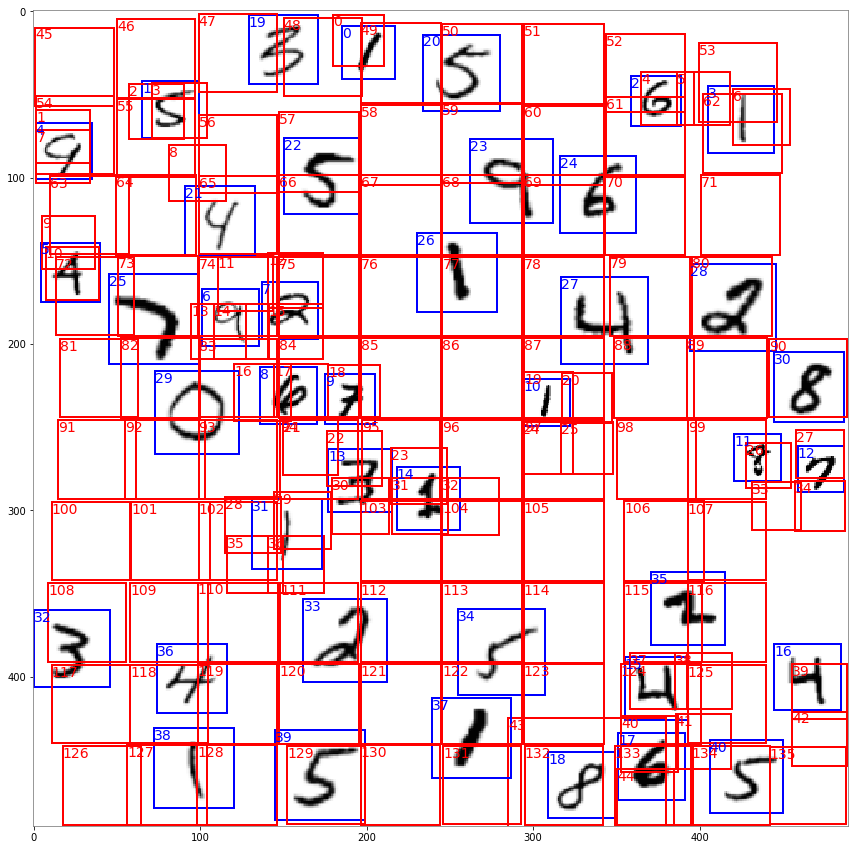

In [29]:
vizResult(test_arrays, test_loss_idx[-1], digit_size_array, digit_central_ref_array)